Repeat exercise 15 of Part 2 (text classification with mostly linear classifiers), now using
an MLP classifier implemented (by you) in TensorFlow.

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install --upgrade tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [4]:
!nvidia-smi

Tue Nov 21 18:39:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [5]:
import time
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model


# Dataset

In [6]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [7]:
def load_train_test_imdb_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    print(data["train"])
    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])
    print(data["test"])
    return data["train"], data["test"]


In [8]:
import os

train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

                                                    text  sentiment
0      10/10 for this film.<br /><br />i'm a british ...          1
1      Nobody said movies had to be realistic did the...          1
2      I won't try to speculate as to what Brando was...          1
3      Ah, the infamous "Guinea Pig" series...I hones...          0
4      If you "get it", it's magnificent.<br /><br />...          1
...                                                  ...        ...
24995  How could I possibly pass up the chance to see...          1
24996  The Lack of content in this movie amazed me th...          0
24997  I've been trying to track down this film just ...          0
24998  "Attack of the Killer Tomatoes" consists mostl...          0
24999  It's good to see that Vintage Film Buff have c...          1

[25000 rows x 2 columns]
                                                    text  sentiment
0      Only if you are crazy about Amber Smith should...          0
1      putting aside t

In [9]:
train_data

,text,sentiment
0,10/10 for this film.<br /><br />i'm a british ...,1
1,Nobody said movies had to be realistic did the...,1
2,I won't try to speculate as to what Brando was...,1
3,"Ah, the infamous ""Guinea Pig"" series...I hones...",0
4,"If you ""get it"", it's magnificent.<br /><br />...",1
...,...,...
24995,How could I possibly pass up the chance to see...,1
24996,The Lack of content in this movie amazed me th...,0
24997,I've been trying to track down this film just ...,0
24998,"""Attack of the Killer Tomatoes"" consists mostl...",0


In [10]:
test_data

,text,sentiment
0,Only if you are crazy about Amber Smith should...,0
1,"putting aside the ""i'm so sure""s and ""totally ...",1
2,Sit back and let Director Bharatbala lead us i...,1
3,Most of the silent films I've seen have been s...,1
4,Another well done moral ambiguity pieces where...,1
...,...,...
24995,"I discovered ""The Patriot"" in a DVD-store and ...",0
24996,I love this show. I watched every episode last...,0
24997,Pertty Kiran comes back to home after completi...,1
24998,The hysterical Hardware Wars is finally out on...,1


In [11]:
df = pd.concat([train_data, test_data], ignore_index=True)
df

,text,sentiment
0,10/10 for this film.<br /><br />i'm a british ...,1
1,Nobody said movies had to be realistic did the...,1
2,I won't try to speculate as to what Brando was...,1
3,"Ah, the infamous ""Guinea Pig"" series...I hones...",0
4,"If you ""get it"", it's magnificent.<br /><br />...",1
...,...,...
49995,"I discovered ""The Patriot"" in a DVD-store and ...",0
49996,I love this show. I watched every episode last...,0
49997,Pertty Kiran comes back to home after completi...,1
49998,The hysterical Hardware Wars is finally out on...,1


In [12]:
x = df['text']
y = df['sentiment']

In [13]:
x

0        10/10 for this film.<br /><br />i'm a british ...
1        Nobody said movies had to be realistic did the...
2        I won't try to speculate as to what Brando was...
3        Ah, the infamous "Guinea Pig" series...I hones...
4        If you "get it", it's magnificent.<br /><br />...
                               ...                        
49995    I discovered "The Patriot" in a DVD-store and ...
49996    I love this show. I watched every episode last...
49997    Pertty Kiran comes back to home after completi...
49998    The hysterical Hardware Wars is finally out on...
49999    This would probably be a good film to see....p...
Name: text, Length: 50000, dtype: object

In [14]:
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    0
49996    0
49997    1
49998    1
49999    0
Name: sentiment, Length: 50000, dtype: int64

# **Pre-Processing**

In [15]:
import nltk
nltk.download('wordnet')

import re
# Consult python regex docs for Regular Expression usage: https://docs.python.org/3/library/re.html

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
stemmer = WordNetLemmatizer()
docs = []

for doc in x:

    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) #re.I -> ignore case

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    word_list = document.split()

    # Lemmatization
    word_list = [stemmer.lemmatize(word) for word in word_list]

    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(word_list)

    # Append all documents into a list 'docs'
    docs.append(document)

In [17]:
print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])


Original review text:
10/10 for this film.<br /><br />i'm a british india doctor, currently in india. the word Beckham put me off, 'cos i'm a die hard Liverpool fan, and personally think that Owen is really cool. Since Liverpool and Man Utd are rivals, i was DEAD sure that i wouldn't watch the film.<br /><br />But then i was in delhi to meet some friends, and i had an early morning flight, so i thought, "what the heck, let's bide time by watching this film", 'cos it was a late night show.<br /><br />What a moron i was. I should've seen this film the day it was released. I guess using Beckham's name was to draw audience attraction (which had back-fired in my case!!!), but then i really can't think of a better title for the film.<br /><br />And Nagra, Knightley (drop dead gorgeous), and Rhys-Myers did a superb job.<br /><br />If you hate football, dislike Manchester United (or England for that matter), then this is DEFINATELY the film for you. In fact, i'm just 29 yrs old, a psychiatris

# **Split dataset**
In the data preprocessing phase, the dataset was partitioned into training, development, and test sets using the train_test_split function from the scikit-learn library, ensuring a representative distribution of sentiment across the subsets. This systematic division allowed for independent model training on the training set, hyperparameter tuning on the development set, and unbiased evaluation on the test set, fostering a robust analysis of model generalization.

## Training Set

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=23828748)

In [19]:
len(x_train)

35000

## Development Set

In [20]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

In [21]:
len(x_dev)

5250

In [22]:
# Calculate the number of documents in each set
num_training_documents = len(x_train)
num_dev_documents = len(x_dev)
num_test_documents = len(x_test)

# Print he results
print(f"Number of Training Documents: {num_training_documents}")
print(f"Number of Development Documents: {num_dev_documents}")
print(f"Number of Test Documents: {num_test_documents}")

Number of Training Documents: 29750
Number of Development Documents: 5250
Number of Test Documents: 15000


## Test Set

In [23]:
len(x_test)

15000

# Tokenization

In [24]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_text(text):
    doc = nlp(text)  # Tokenize the text into sentences
    tokens = []

    for sent in doc.sents:
        for tok in sent:  # Iterate through the words of the sentence
            # Skip non-useful tokens
            if (
                '\n' in tok.text or
                "\t" in tok.text or
                "--" in tok.text or
                "*" in tok.text or
                tok.text.lower() in STOP_WORDS
            ):
                continue

            if tok.text.strip():
                tokens.append(tok.text.replace('"', "'").strip())

    return tokens

In [25]:
X_train_tokenized = [tokenize_text(text) for text in x_train]
X_dev_tokenized = [tokenize_text(text) for text in x_dev]
X_test_tokenized = [tokenize_text(text) for text in x_test]

In [26]:
for item in X_train_tokenized[:2]:
  print(item, '\n')

['totally', 'forgettable', 'movie', 'unbelievable', 'soundtrack', 'd', 'soundtrack', '9', '10', 'cd', 'guitar', 'work', 'nil', 'lofgren', 'superb', 'saw', 'movie', 'year', 'ago', 'check', 'imdb', 'remember', 'wa', 'obsessed', 'getting', 'soundtrack', 'replace', 'range', 'blue', 'soul', 'ballad', 'dose', 'gospel', 'song', 'written', 'arranged', 'produced', 'performed', 'nil', 'lofgren', 'lead', 'guitarist', 'opposite', 'steve', 'van', 'zandt', 'street', 'band', 'dude', 'play', 'vocal', 'handled', 'nil', 'sing', 'good', 'raspy', 'bonnie', 'sheridan', 'great', 'singer', 'tom', 'lepson'] 

['shocked', 'movie', 'ha', 'given', 'star', 'people', 'kidding', 'totally', 'blind', 'art', 'acting', 'directing', 'flaw', 'movie', 'br', 'br', 'admit', 'force', 'sit', 'movie', 'wa', 'bad', 'br', 'br', 'character', 'including', 'digger', 'awful', 'actor', 'mean', 'awful', 'maybe', 'director', 'didn', 'care', 'worse', 'director', 'wa', 'like', 'watching', 'bad', 'school', 'play', 'movie', 'wa', 'course',

# Training Preparation

## TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
# Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_dev_tfidf = vectorizer.transform([" ".join(x) for x in X_dev_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape)

(29750, 5000)


## SVD

In [28]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_dev_svd = svd.transform(X_dev_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## 1-hot Vectors

In [29]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
target_list = [0,1]

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))
print('y_dev_1_hot[0]: {}'.format(y_dev_1_hot[0]))

y_train_1_hot[0]: [0]
y_dev_1_hot[0]: [1]


# Evaluation Preparation

In [30]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

# Baseline Models

## Majority Classifier

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Create a majority classifier that always predicts the most frequent class
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(X_train_svd, y_train)

# Make predictions on the development set
predictions_majority = majority_classifier.predict(X_dev_svd)

# Define target names based on your specific class labels
target_names = ["0", "1"]

# Print the classification report for the majority classifier
print("Majority Classifier:")
print(classification_report(y_dev, predictions_majority, target_names=target_names))


Majority Classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2670
           1       0.49      1.00      0.66      2580

    accuracy                           0.49      5250
   macro avg       0.25      0.50      0.33      5250
weighted avg       0.24      0.49      0.32      5250



In [32]:
from sklearn.metrics import accuracy_score
predictions = majority_classifier.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = majority_classifier.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 49.14%
Test Accuracy:49.73%


## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(solver="liblinear")
clf.fit(X_train_svd, y_train)

predictions = clf.predict(X_dev_svd)
print(classification_report(y_dev, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2670
           1       0.87      0.90      0.88      2580

    accuracy                           0.88      5250
   macro avg       0.88      0.88      0.88      5250
weighted avg       0.88      0.88      0.88      5250



In [34]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(X_dev_svd)
print(f'Validation Accuracy: {accuracy_score(y_dev, predictions)*100:.2f}%')

predictions = clf.predict(X_test_svd)
print(f'Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Validation Accuracy: 88.38%
Test Accuracy:87.69%


In [35]:
print("X_train_svd shape:", X_train_svd.shape)
print("y_train_1_hot shape:", y_train_1_hot.shape)


X_train_svd shape: (29750, 500)
y_train_1_hot shape: (29750, 1)


# MLP Classifier

In [39]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
    input_dim = X_train_svd.shape[1]

    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    # Print model summary to verify the architecture
    print(model.summary())

    # Configures the model for training.
    model.compile(
        loss='binary_crossentropy',  # Change to binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )

    start_training_time = time.time()
    history = model.fit(
        X_train_svd,
        y_train_1_hot,
        validation_data=(X_dev_svd, y_dev_1_hot),
        batch_size=256,
        epochs=100,
        shuffle=True,
        callbacks=[checkpoint]
    )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               64128     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 72449 (283.00 KB)
Trainable params: 72449 (283.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1

## Visualize History

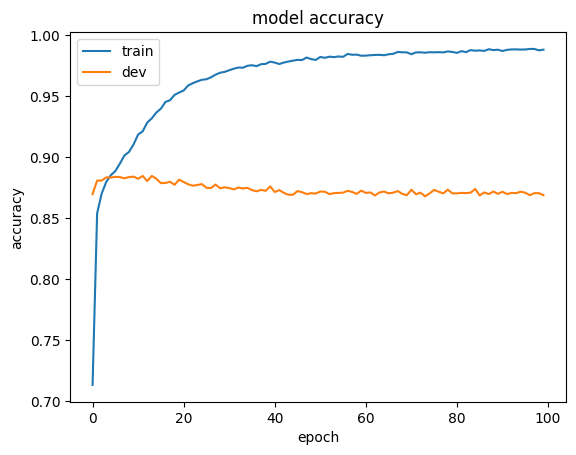

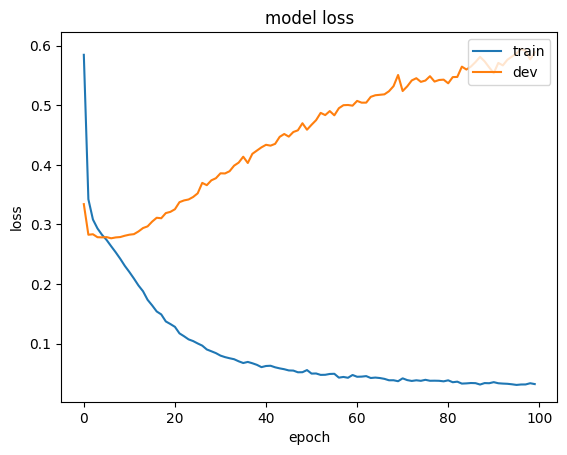

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

As we can see, after 20 epochs, dev loss starts to increase extremely. This fact is an indicator of overfit. That's why we are going to run the model for 20 epochs. \\
However, we also have to tune some hyperparameters too like the number of the hidden layers, the dropout probability and the learning rate too.

In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

  model = Sequential()
  model.add(Dense(128, input_dim=X_dev_svd.shape[1] , activation='relu'))
  model.add(Dense(64,  activation='relu'))
  model.add(Dense(1,  activation='sigmoid'))

  # Load weights from the pre-trained model
  model.load_weights("checkpoints/weights.hdf5")
  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(lr=0.001),
      metrics=["accuracy"]
      )

  predictions = np.argmax(model.predict(X_dev_svd), -1)
  print(classification_report(y_dev, predictions, target_names=target_names))

# Hyperparameter Tuning

In [42]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [43]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from kerastuner.tuners import RandomSearch

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), input_dim=input_dim, activation='relu'))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

    # You can add more layers and dropout rates as needed

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        metrics=["accuracy"]
    )

    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # You can increase this number for a more exhaustive search
    directory='keras_tuner_dir',
    project_name='my_tuning_experiment'
)

# Perform the hyperparameter search
tuner.search(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=100,
    batch_size=256
)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit(
    X_train_svd,
    y_train_1_hot,
    validation_data=(X_dev_svd, y_dev_1_hot),
    epochs=100,
    batch_size=256
)

# Print the summary of the best model
print(best_model.summary())

# Save the best model
best_model.save('best_model.h5')


Trial 5 Complete [00h 01m 03s]
val_accuracy: 0.8834285736083984

Best val_accuracy So Far: 0.8868571519851685
Total elapsed time: 00h 05m 55s
Best:  <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7bbb05ad4ee0>
Epoch 1/100
117/117 [==============================] - 2s 6ms/step - loss: 0.6843 - accuracy: 0.6493 - val_loss: 0.6655 - val_accuracy: 0.8078
Epoch 2/100
117/117 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.8041 - val_loss: 0.5179 - val_accuracy: 0.8550
Epoch 3/100
117/117 [==============================] - 1s 4ms/step - loss: 0.4370 - accuracy: 0.8487 - val_loss: 0.3498 - val_accuracy: 0.8752
Epoch 4/100
117/117 [==============================] - 0s 4ms/step - loss: 0.3391 - accuracy: 0.8658 - val_loss: 0.3021 - val_accuracy: 0.8798
Epoch 5/100
117/117 [==============================] - 1s 4ms/step - loss: 0.3095 - accuracy: 0.8692 - val_loss: 0.2854 - val_accuracy: 0.8830
Epoch 6/100
117/117 [=================

In [44]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - Units in the first hidden layer: {best_hp.get('units1')}")
print(f" - Dropout rate in the first hidden layer: {best_hp.get('dropout1')}")
print(f" - Units in the second hidden layer: {best_hp.get('units2')}")
print(f" - Dropout rate in the second hidden layer: {best_hp.get('dropout2')}")
print(f" - Learning rate: {best_hp.get('learning_rate')}")

Best Hyperparameters:
 - Units in the first hidden layer: 288
 - Dropout rate in the first hidden layer: 0.30000000000000004
 - Units in the second hidden layer: 192
 - Dropout rate in the second hidden layer: 0.2
 - Learning rate: 0.0001246443392229457


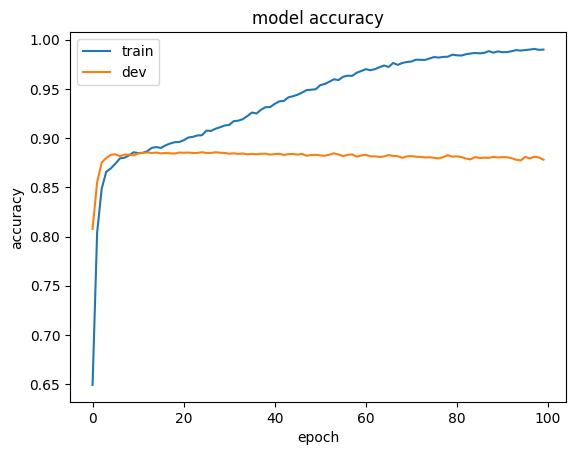

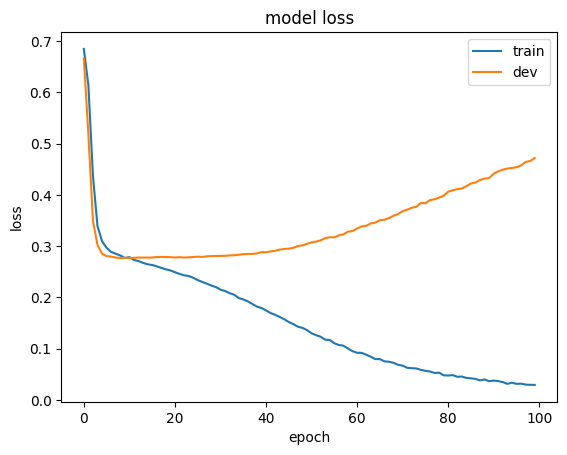

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

Stop at 70